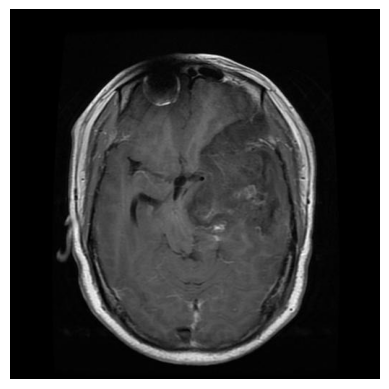

Found 5000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\Shaunak Mishra\Music\tensorfloww\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.7750 - loss: 0.9487 - val_accuracy: 0.8250 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8474 - loss: 0.6516 - val_accuracy: 0.8530 - val_loss: 0.5843 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8666 - loss: 0.5495 - val_accuracy: 0.8730 - val_loss: 0.5133 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8806 - loss: 0.4874 - val_accuracy: 0.8770 - val_loss: 0.4728 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8786 - loss: 0.4628 - val_accuracy: 0.8830 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8942 - loss: 0.4273 - val_accuracy: 0.8640 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8896 - l

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# === Sample display (optional) ===
sample_path = './archive/brisc2025/classification_task/train/glioma/brisc2025_train_00001_gl_ax_t1.jpg'
img = cv2.imread(sample_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/train',
    target_size=(256, 256),
    color_mode='rgb',   
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    './archive/brisc2025/classification_task/test',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# === Callbacks ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)


# === Base model ===
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False


# === Final model ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])


# === Compile ===
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


# === Summary ===
model.summary()


# === Train ===
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr]
)


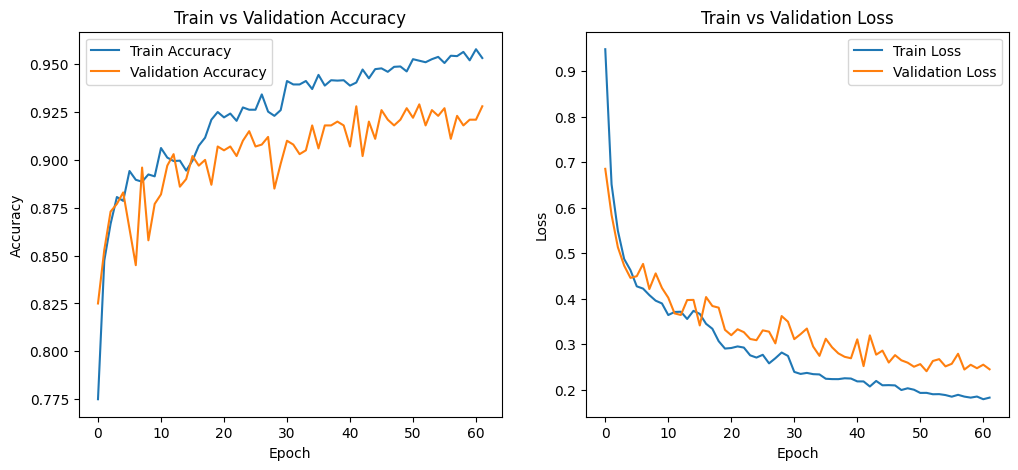

In [26]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()


In [27]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes


32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


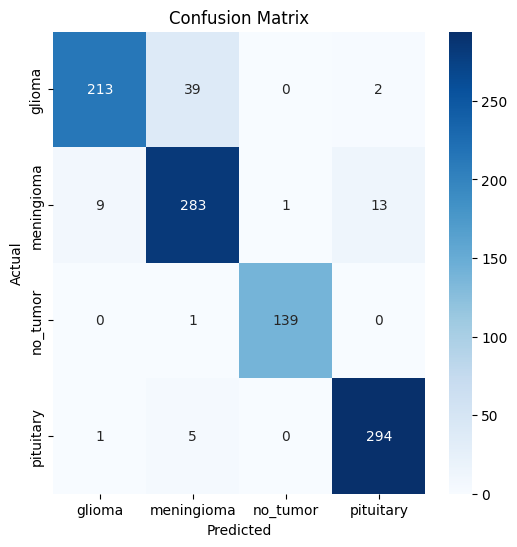

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')

# Detailed per-class report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Test Accuracy: 92.90%
Test Precision: 93.11%
Test Recall: 92.90%
Test F1 Score: 92.87%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.84      0.89       254
  meningioma       0.86      0.92      0.89       306
    no_tumor       0.99      0.99      0.99       140
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.93      0.93      0.93      1000

